In [4]:
from matplotlib import pyplot as plt
import numpy as np
import numba

In [5]:
from dataclasses import dataclass
from typing import Callable

In [16]:
@dataclass
class BoundingBox:
    width: int
    height: int
    center: complex
    extent: complex
    
    def scale(self) -> float:
        """Computes the correct scale to display the selected region.
        
        Returns:
            floating point value that scales pixels to desired complex domain.
        """
        return max(self.extent.real / self.width,
                   self.extent.imag / self.height)
    
    def int_map(self, f) -> np.array:
        """Map a function (with integer output) over the given complex domain.
        
        Returns:
            np.array[int]
        """
        result = np.zeros((self.height, self.width), np.int64)
        scale = self.scale()
        for j in range(self.width):
            for i in range(self.height):
                z = self.center + (i - self.width // 2 + (j - self.height // 2) * 1j) * scale
                result[j, i] = f(z)
        return result
    
    def plot(self, value, name="z", ax=None):
        """Plot `value`.
        
        Returns:
            figure, axis tuple
        """
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        else:
            fig = None
        plot_extent = (self.width + 1j * self.height) * self.scale()
        z1 = self.center - plot_extent / 2
        z2 = z1 + plot_extent
        ax.imshow(value, extent=(z1.real, z2.real, z1.imag, z2.imag))
        ax.set_xlabel(f"$\Re({name})$")
        ax.set_ylabel(f"$\Im({name})$")
        return fig, ax

In [31]:
def iteration_count(f, stop_condition, start, max_iter, *args):
    x = start
    for k in range(max_iter):
        x = f(x, *args)
        if stop_condition(x):
            break
    return k

In [32]:
def radius_2_condition(z: complex) -> bool:
    return (z*z.conjugate()).real >= 4.0

In [33]:
bb = BoundingBox(512, 512, -0.8+0.0j, 3.0+2.0j)

In [34]:
def mandelbrot_ic(max_iter: int):
    def f(c: complex):
        return iteration_count(lambda z, c: z**2 + c, radius_2_condition, 0.0, max_iter, c)
    return f

In [35]:
def julia_ic(c: complex, max_iter: int):
    def f(z0: complex):
        return iteration_count(lambda z, c: z**2 + c, radius_2_condition, z0, max_iter, c)
    return f    

In [36]:
mb = mandelbrot_ic(256)
julia = julia_ic(-1.1193+0.2718j, 256)

In [37]:
%%time
im = bb.int_map(mb)

CPU times: user 3.42 s, sys: 3.81 ms, total: 3.42 s
Wall time: 3.42 s


(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:xlabel='$\\Re(z)$', ylabel='$\\Im(z)$'>)

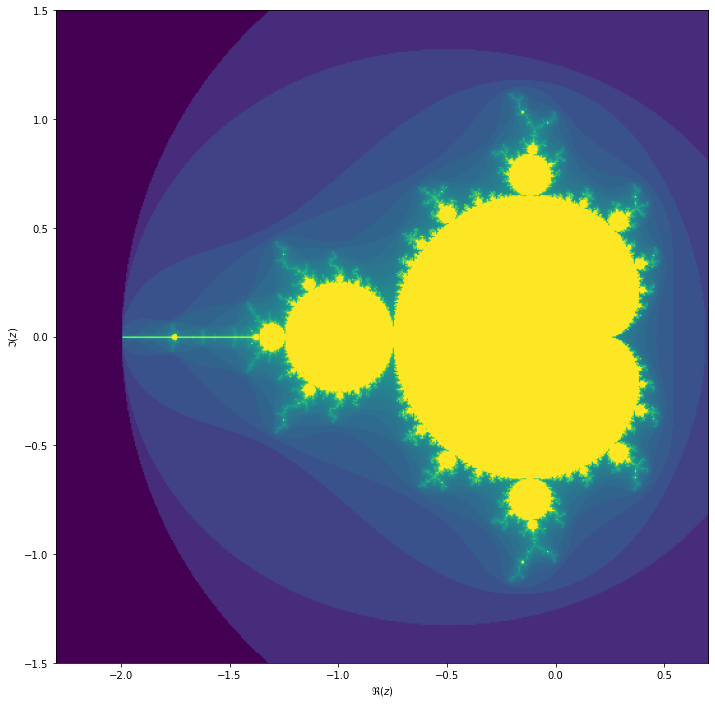

In [38]:
bb.plot(np.log(im+1))